# Testing Delay In-Painting Using CLEAN with EoR and Foregrounds

Jacob Burba and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

{We recommend installing jupyter_contrib_nbextensions and enabling the Table of Contents(2) extension, at which point this section can be removed, as it will be generated automatically.  The simplest way of doing this is ``conda install -c conda-forge jupyter_contrib_nbextensions``. To enable the extension, either go to ``localhost:xxxx/nbextensions`` and switch it on, or use ``jupyter nbextension enable toc2/main``. You'll also need to switch on the option to "Add a Table of Contents cell at the top of the notebook". Then delet this and the following javascript cell. 

If you don't want to install this, then leave the heading and javascript here, and execute the JS cell right before submitting the notebook.
}

In [10]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

Using simulated datasets from RIMEz of the GSM, GLEAM, and a $k^{-2}$ EoR power spectrum, we add RFI flags from the HERA-IDR2 observing season and perform a delay in-painting to fill in RFI gaps using the CLEAN algorithm.  

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, sys, copy
import glob
import hera_cal as hc
import h5py
import time

from datetime import datetime
from hera_cal.io import HERAData
from hera_pspec.conversions import Cosmo_Conversions
from pyuvdata import UVData, UVFlag, utils
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import Rectangle

plt.rcParams.update({'font.size': 12})

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
def waterfall_column(waterfalls, flags, titles, clims=None, clabels=None, cmaps=None, ylims=None, 
                     ylabel='JD - 2458098', extents=None, hspace=.1, figsize=(12,6), dpi=100, fignum=None):
    '''Useful plotting function for the IDR 2.2 memo.'''
    if clims is None:
        clims = [None for i in range(len(waterfalls))]
    if clabels is None:
        clabels = [None for i in range(len(waterfalls))]
    if cmaps is None:
        cmaps = [None for i in range(len(waterfalls))]
    if ylims is None:
        ylims = [None for i in range(len(waterfalls))]
    if not any(isinstance(ex, list) for ex in extents):
        extents = [extents for i in range(len(waterfalls))]
    if fignum is None:
        fig, axes = plt.subplots(len(waterfalls), 1, sharex=True, squeeze=True, figsize=figsize, dpi=dpi)
    else:
        fig, axes = plt.subplots(len(waterfalls), 1, sharex=True, squeeze=True, figsize=figsize, dpi=dpi, num=fignum)
    plt.subplots_adjust(hspace=hspace)
    for ax, wf, f, t, clim, clabel, cmap, ylim, ex in zip(axes, waterfalls, flags, titles,
                                                          clims, clabels, cmaps, ylims, extents):
        with np.errstate(divide='ignore', invalid='ignore'):
            im = ax.imshow(wf / ~f, aspect='auto', extent=ex, cmap=cmap)
        fig.colorbar(im, ax=ax, label=clabel, aspect=8, pad=.025)
        if ax == axes[-1]:
            ax.set_xlabel('Frequency (MHz)')    
        im.set_clim(clim)
        ax.set_ylabel(ylabel)
        ax.set_ylim(ylim)
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.02, 0.9, t, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

### Description

In [3]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2020-02-20 09:15:02.476138


- **Major Step Description:** Apply RFI flags from IDR2 data to simulated visibilities from RIMEz, perform in-painting on simulated data using $\texttt{vis_clean}$ in $\texttt{hera_cal}$, and compute power spectra using $\texttt{hera_pspec}$
- **Minor Variation Description:** 
- **Pipelines Tested:** $\texttt{vis_clean}$, $\texttt{pspec}$
- **Criteria**:
  1. TBD
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* {``pyuvdata``: `ed4515162a333706ddcd0803bb80fcaa09f90a03`}
* {``hera_cal``: `2e5dd382872f649266f334e9f3ded4fc4803f017`}
* {``hera_pspec``: `79c4d17bd5d73097c56313e0338cf107191a2723`}

Versions of other software used in this validation test:

* {``numpy``: v1.17.2}
* {``matplotlib``: v3.1.0}

### Data

The raw data used for each component of the simulated visibilities can be found within `/lustre/aoc/projects/hera/Validation/` in the following subdirectories:

* EoR: `hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5`
* GLEAM: `hera_hex37_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5`
* eGSM: `hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5`

For now, I am using subsets of these full datasets (24 hours of LST and many baselines) because they slow down the analysis.  The full datasets can be used as a final check once the in-painting techniques have been nailed down.  The data subsets are linked via the file paths in the cell below.  They contain the first 1000 integrations and a subset of baselines with |b| <= 30 m.

The following paths reflect the exact locations of all data used in this test:

In [4]:
data_path = "/lustre/aoc/projects/hera/jburba/hera-validation/test-series/3/"
eor_filename = "eor.1000-times.uvh5"
gsm_filename = "egsm.1000-times.uvh5"
gleam_filename = "gleam.1000-times.uvh5"

# Flags are stored in a UVFlag datasets
idr2_flags_filename = "flags.uvh5"
lst_binned_flags_filename = "lst_binned_flags.uvh5"

## Making the master dataset

Load the individual source simulation components, add them to make a summed dataset, and apply RFI flags

In [5]:
bls = [(13, 6), (34, 21)]
polarizations = ['xx']

###
# EoR
###
E = hc.delay_filter.DelayFilter(os.path.join(data_path, eor_filename))
E.read(bls=bls, polarizations=polarizations)

###
# Foregrounds
###
# GSM
F_gsm = hc.delay_filter.DelayFilter(os.path.join(data_path, gsm_filename))
F_gsm.read(bls=bls, polarizations=polarizations)
# GLEAM
F_gleam = hc.delay_filter.DelayFilter(os.path.join(data_path, gleam_filename))
F_gleam.read(bls=bls, polarizations=polarizations)
# Combined foregrounds
F = copy.deepcopy(F_gsm)
F.data += F_gleam.data

###
# Sum EoR + Foregrounds
###
S = copy.deepcopy(F)
S.data += E.data

lsts_hrs = F.lsts * 12 / np.pi

Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


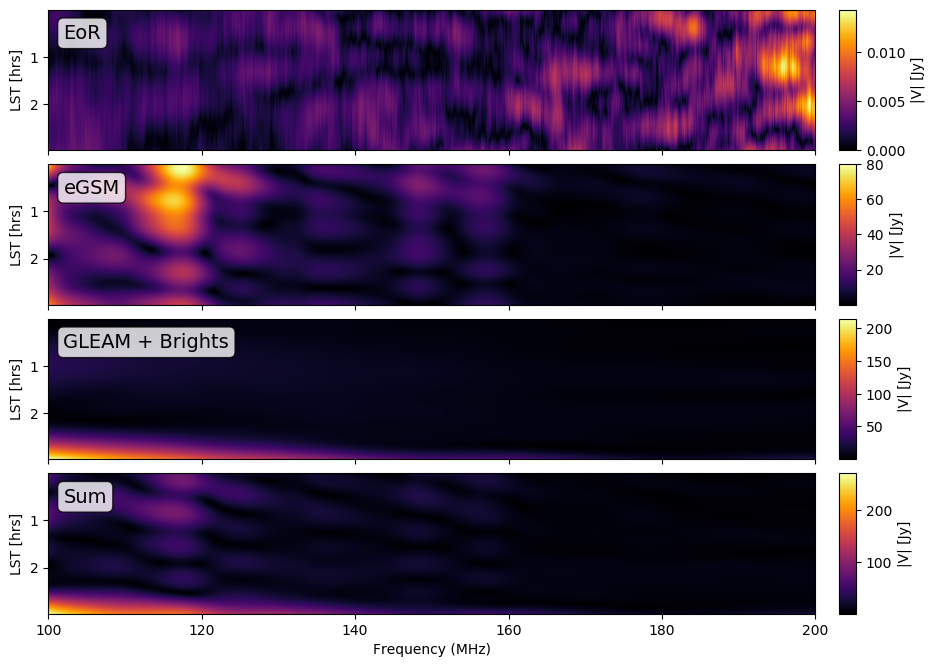

In [6]:
bl_key = (13, 6, 'xx')

waterfalls = [np.abs(E.data[bl_key]), np.abs(F_gsm.data[bl_key]),
              np.abs(F_gleam.data[bl_key]), np.abs(S.data[bl_key])]
flags = [np.zeros_like(S.flags[bl_key])] * len(waterfalls)
titles = ['EoR', 'eGSM', 'GLEAM + Brights', 'Sum']
clabels = ['|V| [Jy]'] * len(waterfalls)
cmaps = ['inferno'] * len(waterfalls)
ylabel = 'LST [hrs]'
extents = [[E.freqs[0] / 1e6, E.freqs[-1] / 1e6, lsts_hrs.max(), lsts_hrs.min()]] * len(waterfalls)

waterfall_column(waterfalls, flags, titles, clabels=clabels, cmaps=cmaps,
                 ylabel=ylabel, extents=extents, figsize=(12, 8))

**Figure 1** | Absolute value of the simulated visibilities from RIMEz for the components used in this work, i.e. EoR, GSM, and Gleam + Brights.  The sum of EoR + eGSM + (GLEAM + Brights) can be seen in the bottom plot.  This summed dataset will be the master dataset for this work while the other components will be used for reference.


### Load RFI flags from UVFlag object

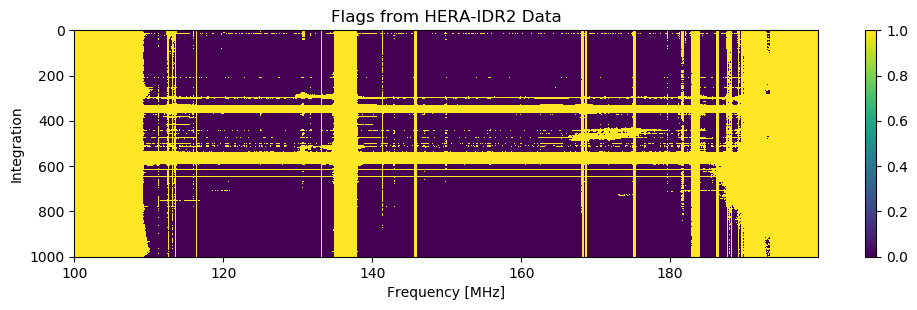

In [7]:
uvf = UVFlag(os.path.join(data_path, lst_binned_flags_filename))

fig = plt.figure(figsize=(12, 3), dpi=100)
cax = plt.imshow(uvf.flag_array[:, 0, :, 0].astype('int'),
                 extent=[uvf.freq_array[0, 0] / 1e6, uvf.freq_array[0, -1] / 1e6, uvf.Ntimes, 0],
                 aspect='auto')
fig.colorbar(cax)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Integration')
plt.title('Flags from HERA-IDR2 Data');

**Figure 2** | RFI flags from 1000 integrations of LST binned HERA-IDR2.2 data.

### Apply RFI flags to Simulated Data

In [8]:
proc_lbls = ['EoR', 'eGSM', 'GLEAM', 'eGSM + GLEAM', 'Sum']
data_containers = [E, F_gsm, F_gleam, F, S]
for data_container in data_containers:
    for bl_key in data_container.data.keys():
        data_container.flags[bl_key] += uvf.flag_array[:, 0, :, 0]

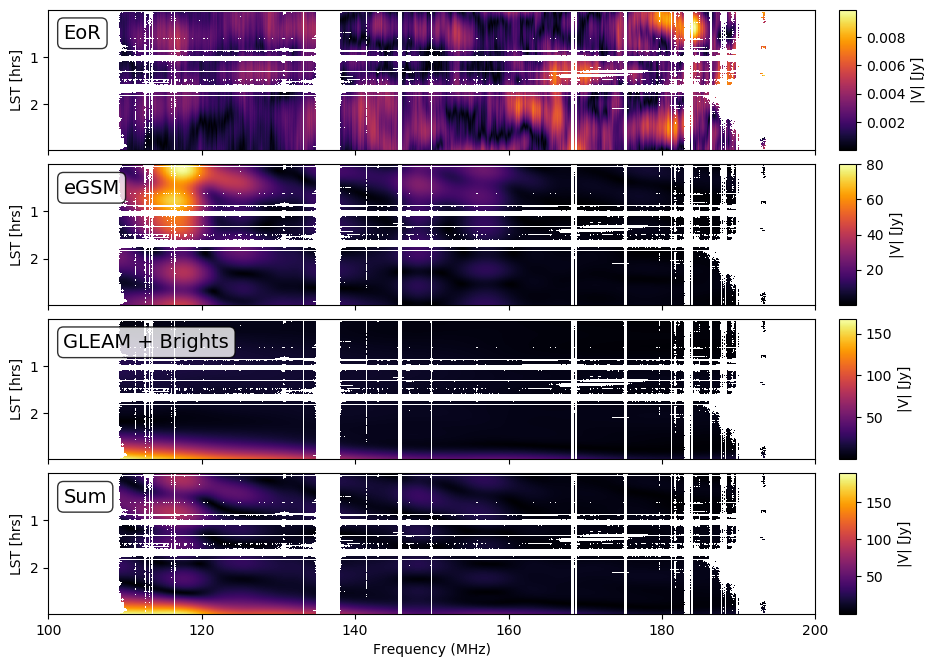

In [9]:
bl_key = (13, 6, 'xx')

waterfalls = [np.abs(E.data[bl_key]), np.abs(F_gsm.data[bl_key]),
              np.abs(F_gleam.data[bl_key]), np.abs(S.data[bl_key])]
flags = [E.flags[bl_key], F_gsm.flags[bl_key], F_gleam.flags[bl_key], S.flags[bl_key]]
titles = ['EoR', 'eGSM', 'GLEAM + Brights', 'Sum']
clabels = ['|V| [Jy]'] * len(waterfalls)
cmaps = ['inferno'] * len(waterfalls)
ylabel = 'LST [hrs]'
extents = [[E.freqs[0] / 1e6, E.freqs[-1] / 1e6, lsts_hrs.max(), lsts_hrs.min()]] * len(waterfalls)

waterfall_column(waterfalls, flags, titles, clabels=clabels, cmaps=cmaps,
                 ylabel=ylabel, extents=extents, figsize=(12, 8))

**Figure 3** | Absolute value of the same simulated visibilities from Figure 1 but with RFI flags applied from LST binned HERA-IDR2.2 data.

## In-painting of Datasets

In-painting of the simulated datasets is performed using `hera_cal.delay_filter.vis_clean` which implements a 1D CLEAN along the frequency axis.  The missing gaps in the data due to RFI flags are "in-painted" with the CLEAN model + residuals from `vis_clean`.  The parameters used when calling the `vis_clean` function to perform the in-painting are defined in the following cell.  The `edgecut_low` and `edgecut_hi` variables set the number of channels at the low and high end of the frequency range that are unused during in-painting.  The edges of the band are typically flagged entirely and as such are unreliable for performing in-painting.

In [37]:
# params from HERA-Team/H1C_IDR2/pipeline/prms_preprocess.yaml under 'fg_filt'
standoff = 50.0
horizon = 1.0
min_dly = 1500.0
tol = 0.0001
maxiter = 100
window = 'tukey'
alpha = 0.2
skip_wgt = 0.5
gain = 0.1
edgecut_low = 150
edgecut_hi = 150
# these params not included in the referenced IDR2.2 yaml file
zeropad = 0
verbose = True

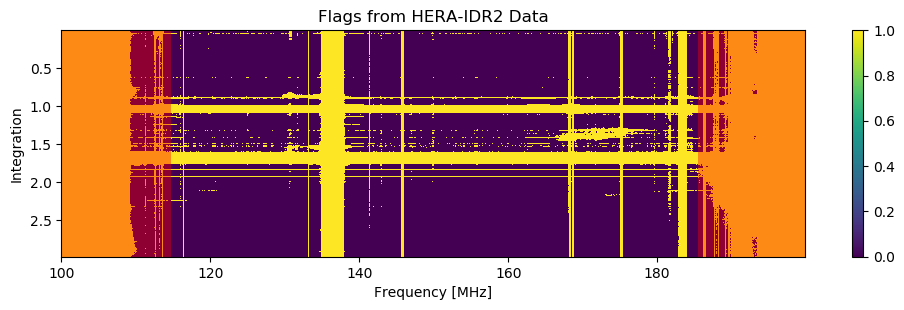

In [38]:
freqs = S.freqs.copy()

fig = plt.figure(figsize=(12, 3), dpi=100)
ax = plt.gca()
cax = plt.imshow(uvf.flag_array[:, 0, :, 0].astype('int'),
                 extent=[uvf.freq_array[0, 0] / 1e6, uvf.freq_array[0, -1] / 1e6, lsts_hrs.max(), lsts_hrs.min()],
                 aspect='auto')
# add rectangles to show what fraction of the band are used for in-painting
rect_low  = Rectangle((freqs[0] / 1e6, lsts_hrs.min()),
                      (freqs[edgecut_low] - freqs[0]) / 1e6,
                      (lsts_hrs.max() - lsts_hrs.min()),
                      linewidth=0.5, facecolor='r', alpha=0.4)
rect_hi  = Rectangle((freqs[-edgecut_hi] / 1e6, lsts_hrs.min()),
                     (freqs[-1] - freqs[-edgecut_hi]) / 1e6,
                     (lsts_hrs.max() - lsts_hrs.min()),
                     linewidth=0.5, facecolor='r', alpha=0.4)
ax.add_patch(rect_low)
ax.add_patch(rect_hi)

fig.colorbar(cax)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Integration')
plt.title('Flags from HERA-IDR2 Data');

**Figure 4** | RFI flags applied from LST binned HERA-IDR2.2 data overlaid with the edgecuts highlighted in red.  The red regions are not used during the delay in-painting process.

In [39]:
for i, hd in enumerate(data_containers):
    print('Processing {} data'.format(proc_lbls[i]))
    print('-' * len('Processing {} data'.format(proc_lbls[i])))
    hd.vis_clean(data=hd.data, flags=hd.flags, ax='freq', horizon=horizon, standoff=standoff,
                 min_dly=min_dly, window=window, alpha=alpha, edgecut_low=edgecut_low,
                 edgecut_hi=edgecut_hi, tol=tol, gain=gain, maxiter=maxiter,
                 skip_wgt=skip_wgt, zeropad=zeropad, overwrite=True, verbose=verbose,
                 output_prefix='clean', add_clean_residual=False)
    print('', end='\n\n')

Processing EoR data
-------------------
Starting CLEAN of (13, 6, 'xx') at 2020-02-20 09:55:51.529554
Starting CLEAN of (34, 21, 'xx') at 2020-02-20 09:55:55.016465


Processing eGSM data
--------------------
Starting CLEAN of (13, 6, 'xx') at 2020-02-20 09:55:59.128968
Starting CLEAN of (34, 21, 'xx') at 2020-02-20 09:56:02.392724


Processing GLEAM data
---------------------
Starting CLEAN of (13, 6, 'xx') at 2020-02-20 09:56:05.877027
Starting CLEAN of (34, 21, 'xx') at 2020-02-20 09:56:07.308388


Processing eGSM + GLEAM data
----------------------------
Starting CLEAN of (13, 6, 'xx') at 2020-02-20 09:56:08.885141
Starting CLEAN of (34, 21, 'xx') at 2020-02-20 09:56:11.618000


Processing Sum data
-------------------
Starting CLEAN of (13, 6, 'xx') at 2020-02-20 09:56:14.322984
Starting CLEAN of (34, 21, 'xx') at 2020-02-20 09:56:17.054127




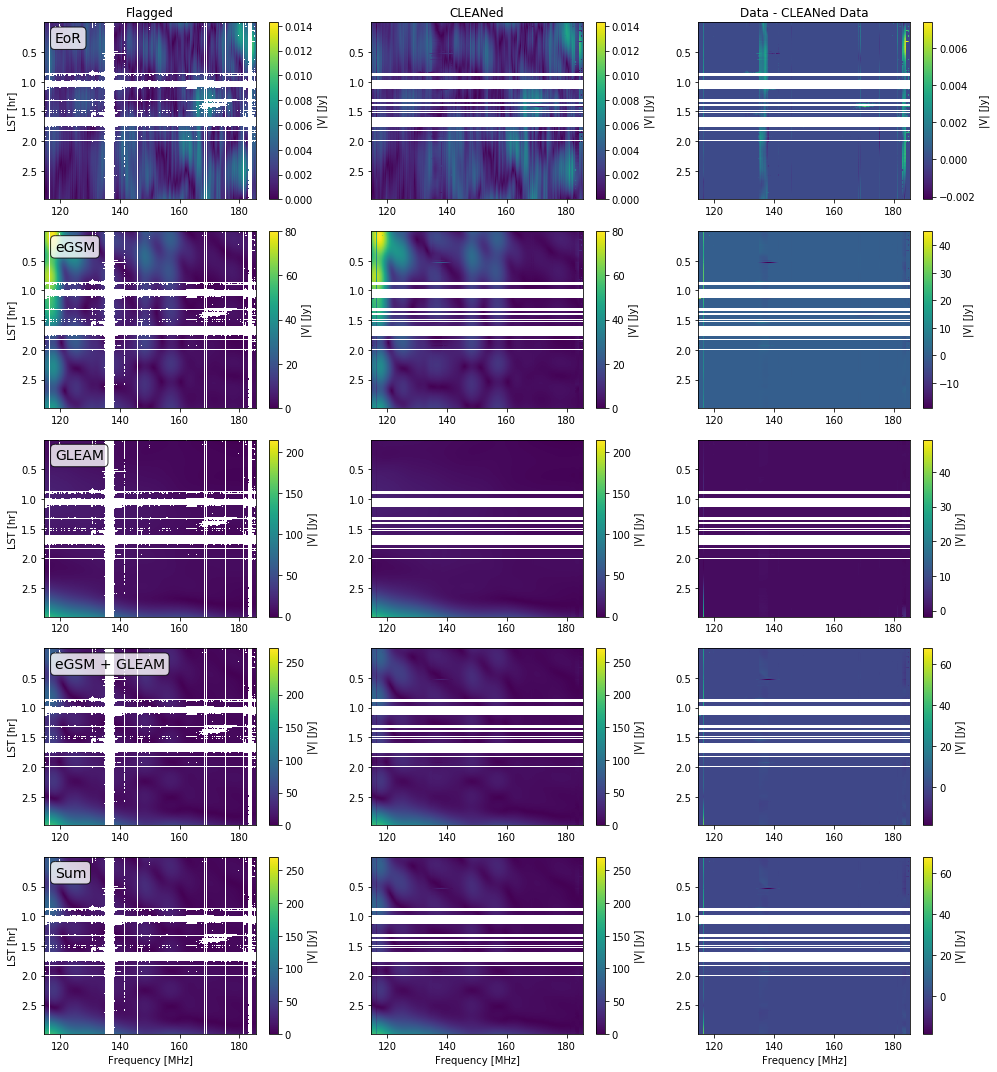

In [40]:
k = (13, 6, 'xx')
extent = [freqs[edgecut_low] / 1e6, freqs[-edgecut_hi] / 1e6, lsts_hrs[-1], lsts_hrs[0]]

fig, axs = plt.subplots(len(proc_lbls), 3, figsize=(14, 3 * len(proc_lbls)))
titles = ['Flagged', 'CLEANed', 'Data - CLEANed Data']
for i, ax in enumerate(axs[0]):
    ax.set_title(titles[i])
for ax in axs[-1]:
    ax.set_xlabel('Frequency [MHz]')
for ax in axs[:, 0]:
    ax.set_ylabel('LST [hr]')

with np.errstate(divide='ignore', invalid='ignore'):
    for i, hd in enumerate([E, F_gsm, F_gleam, F, S]):
        vmin = np.min([np.abs(hd.data[k]).min(), np.abs(hd.clean_data[k]).min()])
        vmax = np.max([np.abs(hd.data[k]).max(), np.abs(hd.clean_data[k]).max()])

        ax = axs[i, 0]
        cax = ax.imshow((np.abs(hd.data[k]) / ~hd.flags[k])[:, edgecut_low:-edgecut_hi],
                        aspect='auto', extent=extent, vmin=vmin, vmax=vmax)
        fig.colorbar(cax, ax=ax, label='|V| [Jy]')

        ax = axs[i, 1]
        cax = ax.imshow((np.abs(hd.clean_data[k]) / ~hd.clean_flags[k])[:, edgecut_low:-edgecut_hi],
                        aspect='auto', extent=extent, vmin=vmin, vmax=vmax)
        fig.colorbar(cax, ax=ax, label='|V| [Jy]')

        ax = axs[i, 2]
        diff = (np.abs(hd.data[k]) - np.abs(hd.clean_data[k]))
        cax = ax.imshow((diff / ~hd.clean_flags[k])[:, edgecut_low:-edgecut_hi], aspect='auto',
                        extent=extent)
        fig.colorbar(cax, ax=ax, label='|V| [Jy]')

        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        axs[i, 0].text(0.05, 0.95, proc_lbls[i], transform=axs[i, 0].transAxes,
                       fontsize=14, verticalalignment='top', horizontalalignment='left', bbox=props)

fig.tight_layout()

**Figure 5** | From left to right: input data with RFI flags, CLEANed data, and input data minus CLEANed data.  From to bottom: EoR, eGSM, GLEAM + Brights, eGSM + GLEAM, and the summed data. The largest clean residuals come from the RIMEz eGSM data.  Integrations where all frequencies are flagged (solid white lines where no data is plotted in the middle and right plots) are ignored during the CLEANing process.

### Spectral Windows Used in Analysis

The spectral windows overlaid on top of the RFI flags used in this analysis are highlighted in Figure 6 below.  Multiple spectral windows were chosen to highlight the difference in effectiveness of the in-painting in the presence of different occupancy numbers of RFI flags.

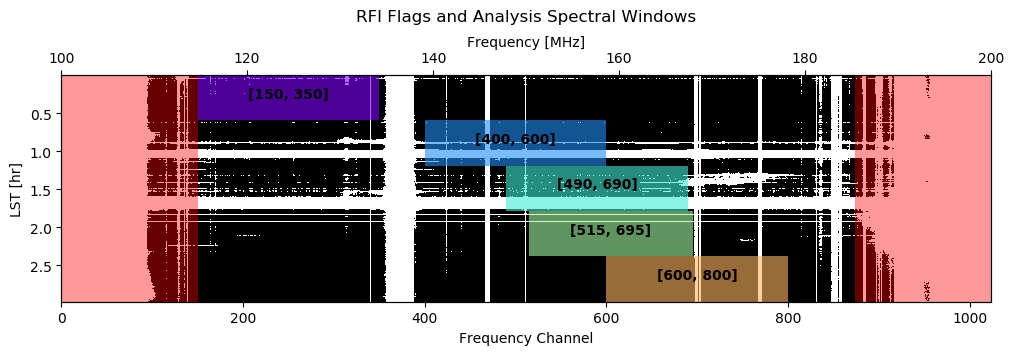

In [49]:
fig = plt.figure(figsize=(12, 3), dpi=100)
ax = plt.gca()
cax = plt.imshow(uvf.flag_array[:, 0, :, 0].astype('int'),
                 extent=[0, uvf.Nfreqs, lsts_hrs.max(), lsts_hrs.min()],
                 aspect='auto', cmap='bone')
# add rectangles to show what fraction of the band are used for in-painting
rect_low  = Rectangle((0, lsts_hrs.min()),
                      edgecut_low,
                      lsts_hrs.max() - lsts_hrs.min(),
                      linewidth=0.5, facecolor='r', alpha=0.4)
rect_hi  = Rectangle((uvf.Nfreqs - edgecut_hi, lsts_hrs.min()),
                     edgecut_hi,
                     lsts_hrs.max() - lsts_hrs.min(),
                     linewidth=0.5, facecolor='r', alpha=0.4)
ax.add_patch(rect_low)
ax.add_patch(rect_hi)

ax.set_xlabel('Frequency Channel')
ax.set_ylabel('LST [hr]')
ax.set_title('RFI Flags and Analysis Spectral Windows', pad=10)

ax_freq = ax.twiny()
tick_inds = np.linspace(0, uvf.Nfreqs - 1, 6).astype('int')
ax_freq.set_xticks(tick_inds)
ax_freq.set_xticklabels(['{:.0f}'.format(x/1e6) for x in uvf.freq_array[0, tick_inds]])
ax_freq.set_xlabel('Frequency [MHz]')

spws = [[150, 350], [400, 600], [490, 690], [515, 695], [600, 800]]
nspws = len(spws)
heights = [(lsts_hrs.max() - lsts_hrs.min()) / nspws] * nspws
colors = plt.cm.rainbow(np.linspace(0.0, 0.75, nspws))
for i_spw, spw in enumerate(spws):
    width = spw[1] - spw[0]
    # height = lsts_hrs.max() - lsts_hrs.min()
    ax.add_patch(Rectangle((spw[0], i_spw * heights[i_spw]), width, heights[i_spw],
                           facecolor=colors[i_spw], alpha=0.6))
    ax.annotate('{}'.format(spw), (spw[0] + width/2, (i_spw + 0.5) * heights[i_spw]),
                color='k', horizontalalignment='center', fontweight='bold')

**Figure 6** | RFI flags applied from LST binned HERA-IDR2.2 data overlaid with the edgecuts highlighted in red.  Highlighted in purple, blue, green, and orange are four different spectral window ranges with the range in frequency channel number overplotted in black.  All spectral windows have a fixed width of 200 frequency channels which corresponds to $\Delta\nu\sim19.5$ MHz.  The blocks simply represent what range of frequencies is used in the analysis.  All times within a given spectral window are used, not those restricted to the rectangles plotted above for each spectral window.

## CLEAN Performance via Delay Transform

To assess how well the CLEAN algorithm is doing at in-painting the data while preserving the underlying power spectrum, we proceed by examining the delay transform of the CLEANed data and residuals over different windows in both time and frequency.

In [44]:
win = 'bh7'

for i_spw, spw in enumerate(spws):
    print('Spectral window = {}'.format(spw))
    print('-' * len('Spectral window = {}'.format(spw)))
    spw_str = 'spw{}'.format(i_spw)
    edgecut = [spw[0], E.Nfreqs - spw[1]]
    print('Processing ', end=' ')
    for i_hd, hd in enumerate(data_containers):
        print('{}'.format(proc_lbls[i_hd]), end=', ')
        hd.fft_data(data=hd.clean_data, window=win, edgecut_low=edgecut[0],
                    edgecut_hi=edgecut[1], overwrite=True, assign='cfft_{}'.format(spw_str))
        hd.fft_data(data=hd.clean_model, window=win, edgecut_low=edgecut[0],
                    edgecut_hi=edgecut[1], overwrite=True, assign='mfft_{}'.format(spw_str))
        hd.fft_data(data=hd.clean_resid, window=win, edgecut_low=edgecut[0],
                    edgecut_hi=edgecut[1], overwrite=True, assign='rfft_{}'.format(spw_str))
        hd.fft_data(data=hd.data, window=win, edgecut_low=edgecut[0],
                    edgecut_hi=edgecut[1], overwrite=True, assign='dfft_{}'.format(spw_str))
        hd.fft_data(data=hd.data, flags=hd.flags, window=win, edgecut_low=edgecut[0],
                    edgecut_hi=edgecut[1], overwrite=True, assign='kfft_{}'.format(spw_str))
    print(end='\n\n')
cosmo_conv = Cosmo_Conversions()
z = cosmo_conv.f2z(freqs.mean())
kparas = np.array(cosmo_conv.tau_to_kpara(z) * F.delays * 1.0e-9)

Spectral window = [150, 350]
----------------------------
Processing  EoR, eGSM, GLEAM, eGSM + GLEAM, Sum, 

Spectral window = [400, 600]
----------------------------
Processing  EoR, eGSM, GLEAM, eGSM + GLEAM, Sum, 

Spectral window = [490, 690]
----------------------------
Processing  EoR, eGSM, GLEAM, eGSM + GLEAM, Sum, 

Spectral window = [515, 695]
----------------------------
Processing  EoR, eGSM, GLEAM, eGSM + GLEAM, Sum, 

Spectral window = [600, 800]
----------------------------
Processing  EoR, eGSM, GLEAM, eGSM + GLEAM, Sum, 



divide by zero encountered in true_divide
invalid value encountered in true_divide


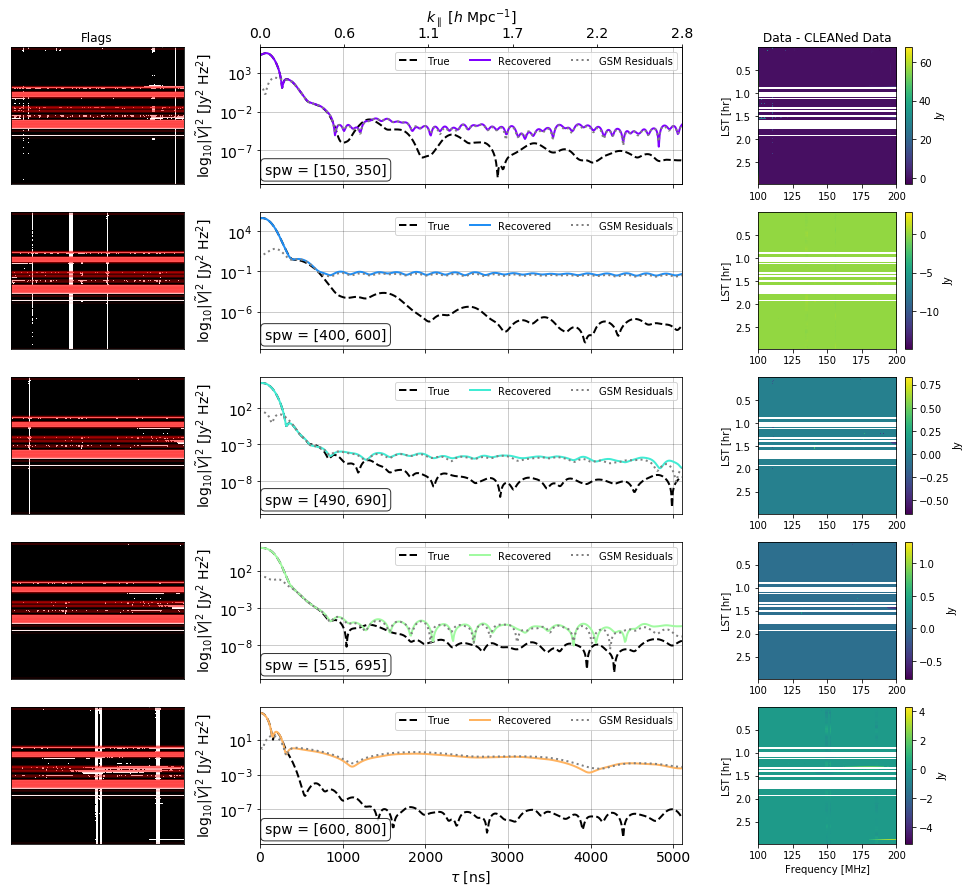

In [50]:
k = (13, 6, 'xx')
spw_data_containers = [[S.dfft_spw0, S.cfft_spw0, F_gsm.rfft_spw0], [S.dfft_spw1, S.cfft_spw1, F_gsm.rfft_spw1],
                       [S.dfft_spw2, S.cfft_spw2, F_gsm.rfft_spw2], [S.dfft_spw3, S.cfft_spw3, F_gsm.rfft_spw3],
                       [S.dfft_spw4, S.cfft_spw4, F_gsm.rfft_spw4]]
avg_flags = np.logical_not(np.all(E.clean_flags[k], axis=1))
delay_xlim = [S.delays[S.Nfreqs//2], S.delays[-1]]
kparas_xlim = [kparas[S.Nfreqs//2], kparas[-1]]
tick_inds = np.linspace(S.Nfreqs//2, S.Nfreqs - 1, 6).astype('int')

fig = plt.figure(figsize=(13.5, 2.5 * nspws))
gs = GridSpec(nspws, 4)

# add a plot on the right showing the residuals (data - in-painted data) for the given spw

for i_spw, spw_data in enumerate(spw_data_containers):
    spw = spws[i_spw]
    # Plot RFI flags for spw
    ax = fig.add_subplot(gs[i_spw, 0])
    cax = ax.imshow(uvf.flag_array[:, 0, spw[0]:spw[1], 0].astype('int'),
                    cmap='bone', aspect='auto', extent=[spw[0], spw[1], uvf.Ntimes, 0])
    ax.hlines(np.arange(uvf.Ntimes)[~avg_flags], spw[0], spw[1], linestyle='-', alpha=0.1, color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    if i_spw == 0: ax.set_title('Flags')
    
    # Plot delay power spectrum for spw
    ax = fig.add_subplot(gs[i_spw, 1:-1])
    ax.plot(S.delays, np.abs(np.average(spw_data[0][k][avg_flags], axis=0))**2,
            c='k', linestyle='--', lw=2, label='True')
    ax.plot(S.delays, np.abs(np.average(spw_data[1][k][avg_flags], axis=0))**2,
            c=colors[i_spw], lw=2, label='Recovered')
    ax.plot(S.delays, np.abs(np.average(spw_data[2][k][avg_flags], axis=0))**2,
            c='0.5', linestyle=':', lw=2, label='GSM Residuals')
    ax.set_xlim(delay_xlim)
    ax.legend(loc='upper right', ncol=len(spw_data))
    ax.set_yscale('log')
    ax.set_ylabel(r'$\log_{10} |\tilde{V}|^2$ [Jy$^2$ Hz$^2$]', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.grid(axis='both', which='both', alpha=0.25, color='k')

    if i_spw == 0:
        ax.set_xticklabels([])
        
        # Twin axis for plotting kparallels
        ax2 = plt.twiny(ax)
        ax2.set_xticks(S.delays[tick_inds])
        ax2.set_xticklabels(['{:.1f}'.format(x) for x in kparas[tick_inds]])
        ax2.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]', fontsize=14)
        ax2.tick_params(which='both', labelsize=14)
    elif i_spw < nspws - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(r'$\tau$ [ns]', fontsize=14)
        
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.012, 0.05, 'spw = {}'.format(spws[i_spw]), transform=ax.transAxes,
            fontsize=14, verticalalignment='bottom', horizontalalignment='left', bbox=props)
    
    ax = fig.add_subplot(gs[i_spw, -1])
    diff = np.abs(S.data[k]) - np.abs(S.clean_data[k])
    cax = ax.imshow((diff / ~S.clean_flags[k])[:, spw[0]:spw[1]],
                    extent=[freqs.min()/1e6, freqs.max()/1e6, lsts_hrs.max(), lsts_hrs.min()],
                    aspect='auto')
    fig.colorbar(cax, ax=ax, label='Jy')
    if i_spw == 0:
        ax.set_title('Data - CLEANed Data')
    elif i_spw == len(spws) - 1:
        ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('LST [hr]')

fig.tight_layout()

**Figure 7** | Delay transform power spectra of the summed visibilities for the different spectral windows (right column).  The flags for each spectral window can be seen in the left column for comparison.  The integrations that were __not__ used in the averaging are highlighted in red.  Spectral windows where there are either no fully flagged frequency channels or where these fully flagged frequency channels are far from the center of the spectral window seem to perform better during in-painting.

divide by zero encountered in true_divide
invalid value encountered in true_divide


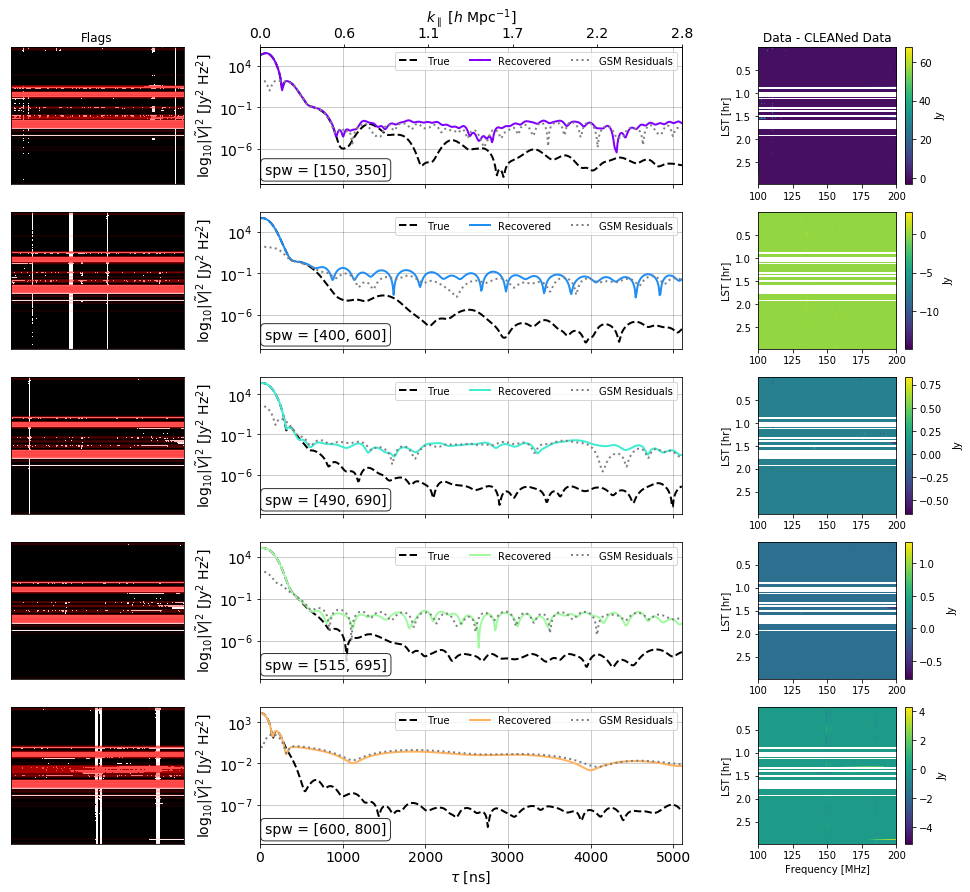

In [51]:
fig = plt.figure(figsize=(13.5, 2.5 * nspws))
gs = GridSpec(nspws, 4)

for i_spw, spw_data in enumerate(spw_data_containers):
    spw = spws[i_spw]
    flags_spw = E.flags[k][:, spw[0]:spw[1]]
    avg_flags = np.sum(flags_spw, axis=1) <= 0.1 * (spw[1] - spw[0])
    # print('Integrations used for spw {} = {}'.format(spw, np.sum(avg_flags)))
    # Plot RFI flags for spw
    ax = fig.add_subplot(gs[i_spw, 0])
    cax = ax.imshow(uvf.flag_array[:, 0, spw[0]:spw[1], 0].astype('int'),
                    cmap='bone', aspect='auto', extent=[spw[0], spw[1], uvf.Ntimes, 0])
    ax.hlines(np.arange(uvf.Ntimes)[~avg_flags], spw[0], spw[1], linestyle='-', alpha=0.1, color='r')
    ax.set_xticks([])
    ax.set_yticks([])
    if i_spw == 0: ax.set_title('Flags')
    
    # Plot delay power spectrum for spw
    ax = fig.add_subplot(gs[i_spw, 1:-1])
    ax.plot(S.delays, np.abs(np.average(spw_data[0][k][avg_flags], axis=0))**2,
            c='k', linestyle='--', lw=2, label='True')
    ax.plot(S.delays, np.abs(np.average(spw_data[1][k][avg_flags], axis=0))**2,
            c=colors[i_spw], lw=2, label='Recovered')
    ax.plot(S.delays, np.abs(np.average(spw_data[2][k][avg_flags], axis=0))**2,
            c='0.5', linestyle=':', lw=2, label='GSM Residuals')
    ax.set_xlim(delay_xlim)
    ax.legend(loc='upper right', ncol=len(spw_data))
    ax.set_yscale('log')
    ax.set_ylabel(r'$\log_{10} |\tilde{V}|^2$ [Jy$^2$ Hz$^2$]', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.grid(axis='both', which='both', alpha=0.25, color='k')

    if i_spw == 0:
        ax.set_xticklabels([])
        
        # Twin axis for plotting kparallels
        ax2 = plt.twiny(ax)
        ax2.set_xticks(S.delays[tick_inds])
        ax2.set_xticklabels(['{:.1f}'.format(x) for x in kparas[tick_inds]])
        ax2.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]', fontsize=14)
        ax2.tick_params(which='both', labelsize=14)
    elif i_spw < nspws - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(r'$\tau$ [ns]', fontsize=14)
        
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.012, 0.05, 'spw = {}'.format(spws[i_spw]), transform=ax.transAxes,
            fontsize=14, verticalalignment='bottom', horizontalalignment='left', bbox=props)
    
    ax = fig.add_subplot(gs[i_spw, -1])
    diff = np.abs(S.data[k]) - np.abs(S.clean_data[k])
    cax = ax.imshow((diff / ~S.clean_flags[k])[:, spw[0]:spw[1]],
                    extent=[freqs.min()/1e6, freqs.max()/1e6, lsts_hrs.max(), lsts_hrs.min()],
                    aspect='auto')
    fig.colorbar(cax, ax=ax, label='Jy')
    if i_spw == 0:
        ax.set_title('Data - CLEANed Data')
    elif i_spw == len(spws) - 1:
        ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('LST [hr]')

fig.tight_layout()

**Figure 8** | Same as in Figure 7, but now only integrations with $\leq$ 25% RFI flag occupancy are used in the time average after performing the delay transform.